## Objective
Explore the Auto Insurance dataset to understand target behavior, feature quality, imbalance, and potential leakage, and to define clear, defensible preprocessing rules for a production-style insurance quote engine.

## Setup

In [ ]:
from pathlib import Path
import subprocess
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)


PROJECT_ROOT = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip())
DATA_DIR = PROJECT_ROOT / "data" / "raw"

RAW_PARQUET = DATA_DIR / "Insurance_claims.parquet"
RAW_CSV = DATA_DIR / "Insurance_claims.csv"

REPORTS = Path("/workspaces/insurance-quote-engine/src/notebooks/reports")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_PARQUET:", RAW_PARQUET, "exists:", RAW_PARQUET.exists())


PROJECT_ROOT: /workspaces/insurance-quote-engine
RAW_PARQUET: /workspaces/insurance-quote-engine/data/raw/Insurance_claims.parquet exists: True


## Load (prefer parquet if available)

In [90]:
if RAW_PARQUET.exists():
    df = pd.read_parquet(RAW_PARQUET)
    source = str(RAW_PARQUET)
elif RAW_CSV.exists():
    df = pd.read_csv(RAW_CSV)
    source = str(RAW_CSV)
else:
    raise FileNotFoundError("Place the dataset at data/raw/insurance_claims.csv (or run ingest to create parquet).")

print("Loaded:", source)
df.shape


Loaded: /workspaces/insurance-quote-engine/data/raw/Insurance_claims.parquet


(58592, 41)

## 2. Data Overview

In [91]:
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [92]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  str    
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  str    
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  str    
 7   model                             58592 non-null  str    
 8   fuel_type                         58592 non-null  str    
 9   max_torque                        58592 non-null  str    
 10  max_power                         58592 non-null  str    
 11  engine_type                       58592 non-null  str    
 12  airbags        

In [93]:
audit = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "missing_count": [int(df[c].isna().sum()) for c in df.columns],
    "missing_pct": [float(df[c].isna().mean()) for c in df.columns],
    "n_unique": [int(df[c].nunique(dropna=True)) for c in df.columns],
})
audit["unique_ratio"] = audit["n_unique"] / max(len(df), 1)
audit = audit.sort_values(["missing_pct", "unique_ratio"], ascending=[False, False]).reset_index(drop=True)

audit.head(30)


,column,dtype,missing_count,missing_pct,n_unique,unique_ratio
0,policy_id,str,0,0.0,58592,1.000000
1,subscription_length,float64,0,0.0,140,0.002389
2,vehicle_age,float64,0,0.0,49,0.000836
3,customer_age,int64,0,0.0,41,0.000700
4,region_code,str,0,0.0,22,0.000375
5,region_density,int64,0,0.0,22,0.000375
6,model,str,0,0.0,11,0.000188
7,engine_type,str,0,0.0,11,0.000188
8,width,int64,0,0.0,10,0.000171
9,gross_weight,int64,0,0.0,10,0.000171


## Save audit artifact


The dataset contains approximately 58,000 insurance policies with 41 features describing:
- customer attributes,
- vehicle specifications,
- region and policy characteristics,
- and vehicle safety features.

Key observations:
- No missing values were observed across features.
- Features include a mix of numeric, categorical, and binary (Yes/No) variables.
- Data quality is high, allowing cleaning to focus on standardisation rather than imputation.


In [94]:
audit_path = REPORTS / "eda_column_audit.csv"
audit.to_csv(audit_path, index=False)
print("Saved:", audit_path)

Saved: /workspaces/insurance-quote-engine/src/notebooks/reports/eda_column_audit.csv


In [95]:
unique_values_df = audit[(audit['n_unique']>2 )& (audit['dtype'] == 'str')]
cat_columns = unique_values_df['column']
for col in cat_columns:
    print(f"{col} values: {df[col].unique()}")

policy_id values: <ArrowStringArray>
['POL045360', 'POL016745', 'POL007194', 'POL018146', 'POL049011', 'POL053680',
 'POL053943', 'POL002857', 'POL028225', 'POL047631',
 ...
 'POL056167', 'POL012989', 'POL027287', 'POL000226', 'POL036713', 'POL019269',
 'POL001254', 'POL019859', 'POL014061', 'POL054184']
Length: 58592, dtype: str
region_code values: <ArrowStringArray>
[ 'C8',  'C2', 'C10', 'C13',  'C7',  'C5',  'C3', 'C19',  'C9', 'C15',  'C6',
 'C11',  'C1', 'C14', 'C17', 'C12',  'C4', 'C21', 'C16', 'C18', 'C22', 'C20']
Length: 22, dtype: str
model values: <ArrowStringArray>
['M4', 'M9', 'M1', 'M5', 'M7', 'M6', 'M8', 'M3', 'M2', 'M10', 'M11']
Length: 11, dtype: str
engine_type values: <ArrowStringArray>
[            '1.5 L U2 CRDi',                    'i-DTEC',
         'F8D Petrol Engine', '1.5 Turbocharged Revotorq',
     '1.2 L K Series Engine',         'K Series Dual jet',
                      'K10C',                   '1.0 SCe',
        '1.2 L K12N Dualjet',                     

## 3. Target Variable Analysis (`claim_status`)

In [96]:
df["claim_status"].value_counts(normalize=True)

claim_status
0    0.936032
1    0.063968
Name: proportion, dtype: float64

In [97]:
df["claim_status"].value_counts()

claim_status
0    54844
1     3748
Name: count, dtype: int64

The target variable `claim_status` indicates whether a claim was filed for a given policy.

Class distribution:
- No claim (`0`): ~93.6%
- Claim (`1`): ~6.4%

This strong class imbalance is expected in insurance datasets, where claims are rare events.

**Implications:**
- This is a probabilistic risk modeling problem, not a hard classification task.
- Accuracy is not an appropriate evaluation metric.
- Models should be evaluated using imbalance-aware metrics such as PR-AUC, ROC-AUC, and recall-focused measures.
- The model output will be interpreted as the probability of claim, which feeds downstream pricing logic.


## 4. Feature Audit & Structure

### 4.1 Identifier Detection

In [98]:
id_like = audit.loc[audit["unique_ratio"] > 0.9, "column"].tolist()
id_like


['policy_id']

The column `policy_id` has a unique value for every row (unique ratio ≈ 1.0), indicating that it is a pure identifier.

**Decision:**
- `policy_id` will be excluded from modeling features to prevent memorisation and ensure generalisation.
- It may be retained separately for traceability or auditing purposes.


In [99]:
(REPORTS / "eda_id_like_columns.txt").write_text("\n".join(id_like))


9

### 4.2 Binary Feature Dominance

In [100]:
cat_cols = df.select_dtypes(include="object").columns.tolist()

cat_summary = []
for c in cat_cols:
    vc = df[c].value_counts(normalize=True)
    cat_summary.append({
        "column": c,
        "top_category": vc.index[0],
        "top_pct": vc.iloc[0],
        "n_unique": df[c].nunique()
    })

cat_df = pd.DataFrame(cat_summary).sort_values("top_pct", ascending=False)
cat_df.head(15)


/tmp/ipykernel_6777/3227232767.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include="object").columns.tolist()


,column,top_category,top_pct,n_unique
27,is_speed_alert,Yes,0.993805,2
23,is_power_steering,Yes,0.979366,2
11,is_parking_sensors,Yes,0.959500,2
10,is_tpms,No,0.760752,2
13,rear_brakes_type,Drum,0.760752,2
22,is_central_locking,Yes,0.724246,2
26,is_ecw,Yes,0.724246,2
21,is_power_door_locks,Yes,0.724246,2
17,is_rear_window_wiper,No,0.710575,2
18,is_rear_window_washer,No,0.710575,2


In [101]:
cat_df.to_csv(REPORTS / "eda_categorical_summary.csv", index=False)


Several vehicle safety features are binary (Yes/No) and highly skewed, with a dominant majority class, for example:
- `is_speed_alert` (~99% Yes)
- `is_power_steering` (~98% Yes)
- `is_parking_sensors` (~96% Yes)

**Interpretation:**
- High dominance does not imply lack of predictive value.
- Such features may still contribute via interactions or non-linear effects in tree-based models.

**Decision:**
- Dominant binary features are retained initially.
- Their usefulness will be validated later using feature importance and explainability techniques.

## Numeric feature distributions

In [102]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols


['subscription_length',
 'vehicle_age',
 'customer_age',
 'region_density',
 'airbags',
 'displacement',
 'cylinder',
 'turning_radius',
 'length',
 'width',
 'gross_weight',
 'ncap_rating',
 'claim_status']

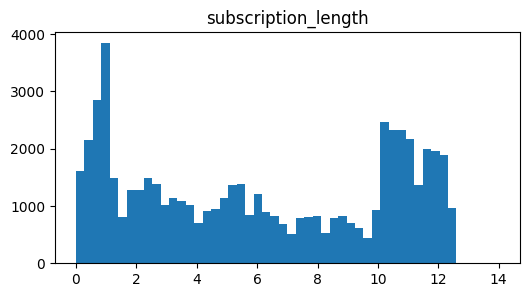

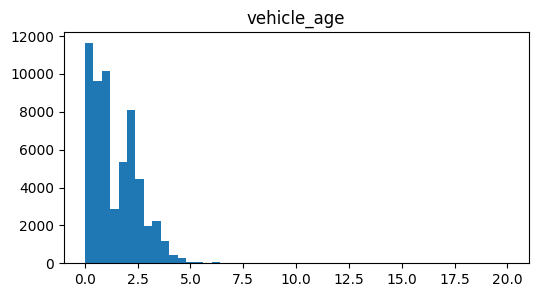

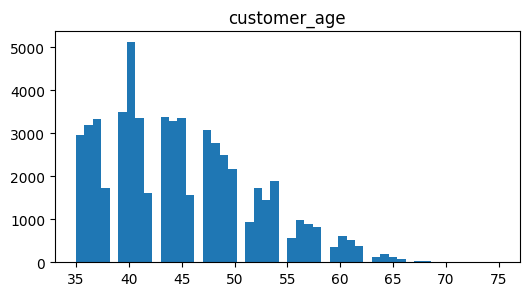

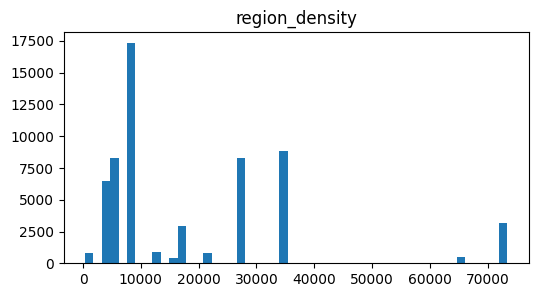

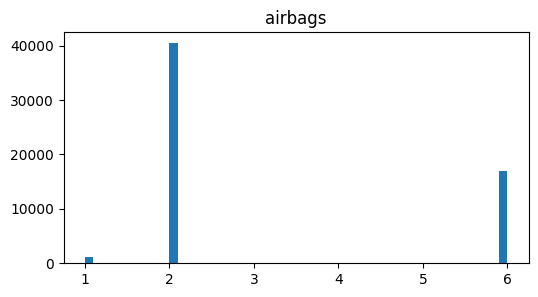

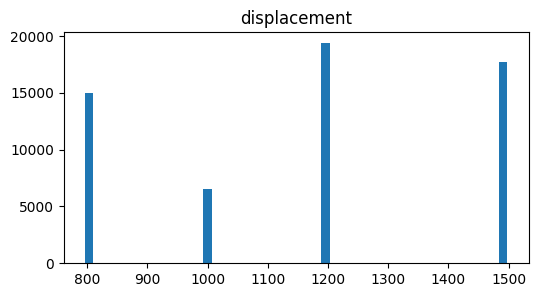

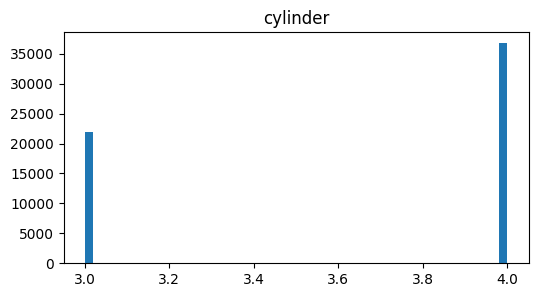

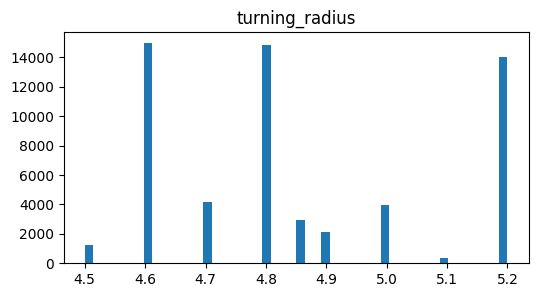

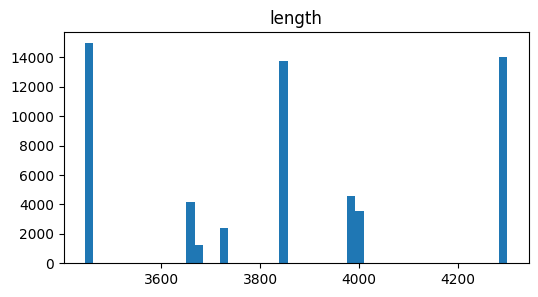

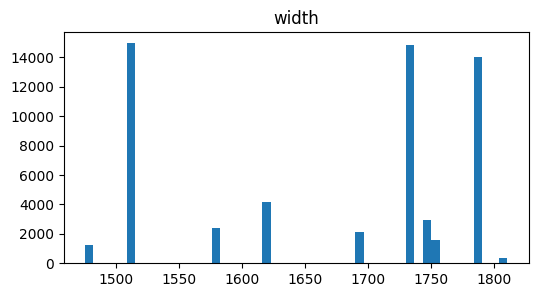

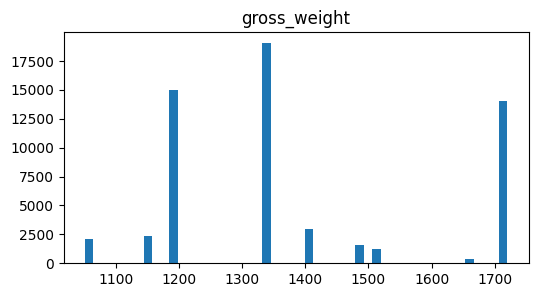

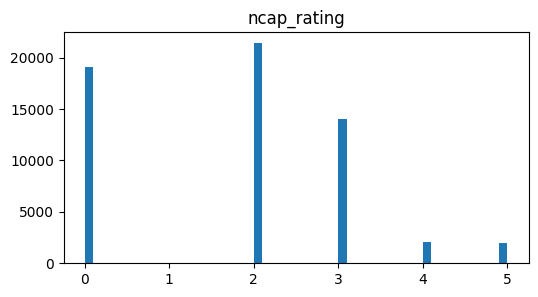

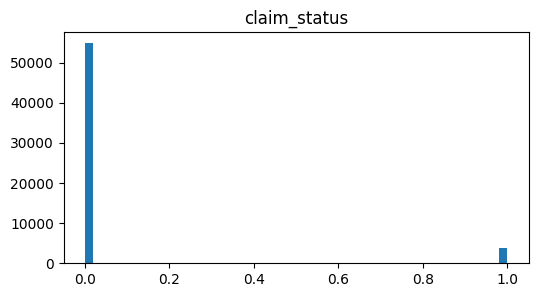

In [103]:
for c in num_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(df[c], bins=50)
    plt.title(c)
    plt.show()


## 7. EDA Conclusions & Pipeline Decisions

This exploratory analysis leads to the following concrete pipeline decisions:

- Target variable: `claim_status` (binary, highly imbalanced)
- ِDivide the max_power and max_torque 
- Modeling objective: estimate probability of claim
- Identifier handling: drop `policy_id` from modeling features
- Binary features: convert Yes/No to 0/1, retain initially
- Categorical features: encode in feature engineering stage
- Feature parsing: extract numeric signal from torque/power strings
- Missing values: no imputation required
- Evaluation strategy: use imbalance-aware metrics

These decisions are directly implemented in the subsequent data cleaning and feature engineering steps.